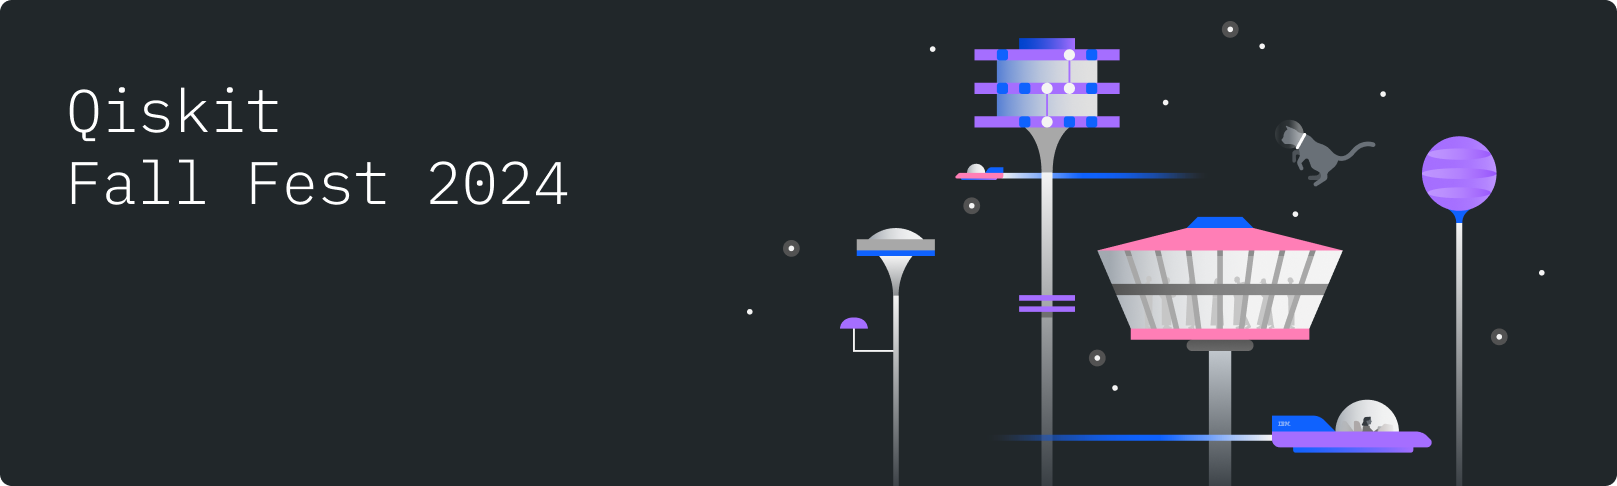

# <div style="text-align: center">**From Classical to Quantum k-Nearest Neighbors Classifier**

<div style="text-align: justify"> The k-Nearest Neighbors (k-NN) algorithm is a popular method in classical machine learning that classifies data points based on the labels of their closest neighbors. While powerful, the classical k-NN relies on computing distances in high-dimensional space, which can become computationally expensive with large datasets.

In this notebook, we explore a quantum approach to k-NN. By leveraging quantum principles, specifically the SWAP test for similarity measurements, we can represent data in quantum states, which may offer computational advantages for high-dimensional data. The quantum k-NN classifier:

This notebook will guide you through the differences between classical and quantum approaches to k-NN and demonstrate how the SWAP test can replace classical distance calculations to enable a quantum version of this classic algorithm. </div>


Install the required packages and import the dependencies

In [11]:
!pip install --upgrade pip
!pip install qiskit[visualization]
!pip install qiskit_ibm_runtime
!pip install matplotlib


In [12]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.primitives import StatevectorSampler
from qiskit import qasm2
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from aux_functions import *


If you want to participate in the challenge, just state your *email address* and the location (**BI** if you are in Bilbao or **DO** if you are in Donostia) in the following variables:

In [13]:
%env email ="diegogerwig@gmail.com"
%env location = "BI" 

env: email="diegogerwig@gmail.com"
env: location="BI"


## **1. Define and visualize the training dataset and testing dataset**

<div style="text-align: justify"> Let us start defining the training set and test set for our k-NN classifiers. The training set consists of labeled 2D points used to "teach" the classifier how to group similar points. The test set contains unlabeled points that the classifier will attempt to label based on their proximity to points in the training set. Each data point is represented as a coordinate pair, making it easy to visualize in a 2D space.

### 1.1. Define the data

Define the training data, the training labels and the test data.

In [14]:
training_data = [
    [30.4, 10.6], [38.6, 42.4], [11.6, 18.8], [38.8, 29.7], [7.7, 23.8],
    [8.8, 44.0], [1.2, 37.2], [15.8, 6.3], [11.1, 24.7], [48.0, 33.9],
    [68.0, 60.4], [84.9, 84.8], [67.1, 50.5], [78.3, 56.9], [61.7, 61.8],
    [53.9, 77.7], [64.0, 91.3], [67.4, 77.0], [74.2, 51.0], [80.6, 86.1]
]

training_labels = [
    'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1',
    'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1',
    'Class 2', 'Class 2', 'Class 2', 'Class 2', 'Class 2',
    'Class 2', 'Class 2', 'Class 2', 'Class 2', 'Class 2'
]

test_data = [
    [20.0, 30.0], [80.0, 80.0], [45.0, 45.0], [50.0, 50.0]
]


### 1.2. Visualize both datasets 

Use the function _plot_data(...)_ defined in the **aux_functions.py** file to visualize the datasets.

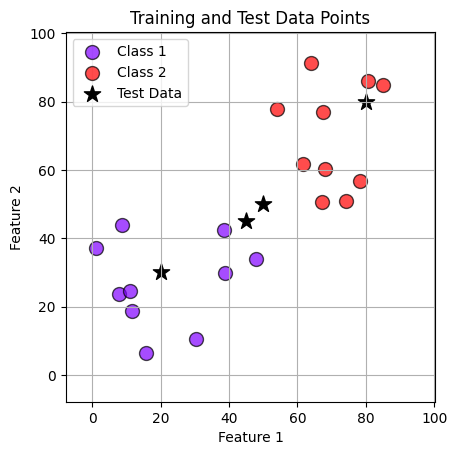

In [15]:
plot_data(training_data, training_labels, test_data)

## **2. Classic k-Nearest Neighbors (k-NN) classifier**

The k-Nearest Neighbors (k-NN) classifier is a simple, instance-based algorithm for classifying data points. Here are the steps to construct a basic k-NN classifier:

> 1. **Distance Calculation:** For a new (test) data point, calculate the distance from this point to each point in the training set. Common distance metrics include Euclidean and Manhattan distances.
> 2. **Select Neighbors:** Identify the k closest points (neighbors) to the test point based on the calculated distances.
> 3. **Majority Voting:** Determine the most common label among these k neighbors. This label is then assigned to the test point.
> 4. **Classification:** Repeat for each test point to classify all points in the dataset.

### 2.1. Distance calculation

Define a function that given two n-dimensional points returns the Euclidean distance between them.

In [16]:
def euclidean_distance(point1, point2):
    """Calculate the Euclidean distance between two points."""
    
    distance = sum((p1 - p2) ** 2 for p1, p2 in zip(point1, point2)) ** 0.5
    
    return distance


In [17]:
#Do not modify the following code
point1 = [5.4, 7.6, 4.1]
point2 = [1.9, 9.1, 2.3]

distance = euclidean_distance(point1, point2)

In [18]:
submit_answer_q1(euclidean_distance)

Your answer is correct!


### 2.2. Classification function

Define a function *classify_knn(...)* that identifies the *k* closest points for each point in the test set. Afterward, it returns the label of each point, performing a majority vote among the *k* labels.

In [ ]:
def classify_knn(X_train, y_train, X_test, k=3):
   """Classify the test points using the k-NN algorithm and returns a list with their labels."""
   
   predictions = []
   for x_test in X_test:
       # Calculate distances from x_test to all points in X_train
       distances = [euclidean_distance(x_test, x_train) for x_train in X_train]
       
       # Find the k nearest neighbors and their labels
       k_indices = sorted(range(len(distances)), key=lambda i: distances[i])[:k]
       k_nearest_labels = [y_train[i] for i in k_indices]
       
       # Majority vote for the most common label
       prediction = max(set(k_nearest_labels), key=k_nearest_labels.count)
       predictions.append(prediction)
   
   return predictions

### 2.3. Perform classification

Use the previously defined function to classify the test data using *k={3}*.

In [21]:
# Returns a list containing the classification for each test point for k=3

predictions = classify_knn(training_data, training_labels, test_data, k=3)

In [22]:
submit_answer_q2(classify_knn)

Your answer is correct!


## **3. Quantum k-Nearest Neighbors (k-NN) classifier**

The Quantum k-Nearest Neighbors (k-NN) classifier is a simple, instance-based algorithm for classifying data points. Here are the steps to construct a basic k-NN classifier:

> 1. **Encode Classical Data as Quantum States**: Classical data points are transformed into quantum states using specific encoding techniques.
> 2. **Measure the Similarity Using Quantum Circuits**: Instead of Euclidean distance, the quantum k-NN uses the SWAP test, a quantum operation, to measure similarity between data points.
> 3. **Classify based on Quantum "Distances**: By finding the most similar quantum states among training data, the classifier assigns labels to test points.

### 3.1. Encoding the data

Let us now explore normalization and angle encoding, two key methods for transforming classical information into quantum states. Encoding data in quantum states allows us to use quantum computation to process classical data, leveraging quantum properties like superposition.

We will focus on:

> 1. **Normalization**: Quantum states must have unit norm, so classical data often needs to be normalized before encoding. This step ensures data compatibility with quantum state requirements, enabling accurate quantum representation.
> 2. **Angle Encoding**: This method maps normalized data values to rotation angles applied to qubits. By encoding data into qubit rotations, we can represent continuous values effectively in a quantum state, capturing the data's variation through angles.

This approach is widely used in quantum machine learning and optimization. Let’s explore how to prepare quantum states from classical data using normalization and angle encoding.


Create a function *normalize_dataset* that given a list or array of points return the normalized dataset scaled to the specified range, by default, [0,1].

In [24]:
def normalize_dataset(dataset, range_min=0, range_max=1):
    """
    Normalizes a dataset to a specified range [range_min, range_max] according to:

    normalized_dataset=range_min+((dataset−min_vals)⋅(range_max−range_min) / range_vals)

    Args:
        dataset (array-like): 2D list or numpy array where each row is a data point and each column is a feature.
        range_min (float): Minimum value of the normalized range.
        range_max (float): Maximum value of the normalized range.

    Returns:
        np.ndarray: Normalized dataset with values scaled to the specified range.
    """
    
    dataset = np.array(dataset, dtype=float)  # Convert to NumPy array for convenience
    
    # Find the minimum and maximum of each feature (column-wise)
    min_vals = np.min(dataset, axis=0)
    max_vals = np.max(dataset, axis=0)

    # Avoid division by zero by setting zero range values to 1
    range_vals = np.where(max_vals - min_vals == 0, 1, max_vals - min_vals)
    
    # Normalize the dataset to the specified range
    normalized_dataset = range_min + ((dataset - min_vals) * (range_max - range_min) / range_vals)
    
    return normalized_dataset


In [25]:
#Do not modify the following code
dataset = [ 
    [4.9, 9.9, 3.2],
    [6.5, 2.9, 5.8],
    [3.5, 9.4, 9.4]
    ]

norm_dataset = normalize_dataset(dataset, 0 , 1)

In [26]:
submit_answer_q3(normalize_dataset)

Your answer is correct!


Create a function *encode_data_angle* that given a list of data points, returns the circuit that performs angle encoding using $R_y$ gates.

In [30]:

def encode_data_angle(data):
    """
    Encode classical data into a quantum circuit using angle encoding.
    
    Args:
        data (list): A list of classical data points (e.g., features of a sample).
    
    Returns:
        QuantumCircuit: Quantum circuit that encodes the classical data.
    """
    num_qubits = len(data)
    qc = QuantumCircuit(num_qubits)

    # Encode each data point as a quantum rotation
    for i, value in enumerate(data):
        angle = 2 * np.arctan(value)
        # Ry rotation based on the value in the angle
        qc.ry(angle, i) 
    
    return qc


In [31]:
#Do not modify the following code
data = [0.0, 1.0]

qc = encode_data_angle(data)

In [32]:
submit_answer_q4(encode_data_angle)

Your answer is correct!


## 3.2. Measuring and Computing Similarity Between Quantum States

Now we explore techniques for measuring and computing similarity between quantum states—a fundamental task in quantum information processing and quantum machine learning. By quantifying how “close” two quantum states are, we can analyze relationships in quantum data, classify quantum states, or even optimize quantum algorithms.

To compute the similarity between two quantum states, we commonly use fidelity or inner product measures:

> 1. **Fidelity**: Fidelity measures how close two quantum states are, giving a value between 0 and 1, where 1 means identical states. For pure states ∣$\psi$⟩ and ∣$\phi$⟩, fidelity is calculated as $∣⟨\psi∣\phi⟩∣^2$.

> 2. **SWAP Test**: This quantum circuit estimates similarity by entangling and measuring the two states. If the two states are identical, the measurement yields a predictable outcome, giving an efficient similarity measure without directly calculating the inner product.

These techniques allow us to quantify the “closeness” between quantum states, a crucial step in quantum machine learning and data analysis. Now take a look at the following circuit that implements the SWAP Test.

![title](c.png)

Implement a funtion that construct the circuit to measure the similarity between two quantum states

In [81]:
from qiskit import ClassicalRegister

def swap_test(qc, qubits_a, qubits_b, num_qubits):
    """
    Apply SWAP test to measure similarity between two quantum states.
    
    Args:
        qc (QuantumCircuit): Quantum circuit to apply the SWAP test on.
        qubits_a (list): List of qubit indices for the first quantum state.
        qubits_b (list): List of qubit indices for the second quantum state.
    
    Returns:
        QuantumCircuit: Updated quantum circuit with SWAP test applied.
    """
    # Prepare ancilla
    ancilla = qc.num_qubits - 1
    qc.h(ancilla)
    
    # Apply controlled-SWAP between pairs
    for q_a, q_b in zip(qubits_a, qubits_b):
        qc.cx(q_b, q_a)
        qc.ccx(ancilla, q_a, q_b)
        qc.cx(q_b, q_a)
    
    qc.h(ancilla)
    
    # Add measurement
    cr = ClassicalRegister(qc.num_qubits)
    qc.add_register(cr)
    qc.measure_all()
    
    return qc

In [80]:
#Do not modify the following code
num_qubits = 5
qc = QuantumCircuit(num_qubits)
qc = swap_test(qc, range(1, len(data) + 1), range(len(data) + 1, num_qubits))

TypeError: swap_test() missing 1 required positional argument: 'num_qubits'

In [78]:
submit_answer_q5(swap_test)

Your answer is incorrect. Try again.


Implement the function *compute_similarity(...)* that creates a quantum circuit that computes the similarity between test and training data using the SWAP test.

In [ ]:

def compute_similarity(training_data, test_data):
    """
    Args:
        test_data (list): Classical data of the test sample.
        training_data (list): Classical data of a training sample.
        encode_data: Function that implements the angle encoiding
    Returns:
        QuantumCircuit: Quantum circuit that encodes both test and training data and applies the SWAP test.
    """
    num_qubits = len(test_data) + len(training_data) + 1  # +1 for the ancilla qubit
    qc = QuantumCircuit(num_qubits)
    
    # Encode test data into the first qubits (starting from qubit 1)
    qc_aux = encode_data_angle(test_data)
    qc.compose(qc_aux, qubits=[1, len(test_data)], inplace=True)
    
    # Encode training data into the second set of qubits
    
    
    # Apply SWAP test between the test and training qubits
   
    
    return qc
    


In [ ]:
#Do not modify the following code

data_s1 = [0.6, 0.5]
data_s2 = [0.5, 0.6]

qc = compute_similarity(data_s1, data_s2)

In [ ]:
submit_answer_q6(compute_similarity)

## 3.3. Simulate the quantum circuit

To simulate a quantum circuit in Qiskit using the StatevectorSampler, you follow these main steps:

> 1. **Initialize StatevectorSampler**: Set up the StatevectorSampler, which is a tool within Qiskit's primitives module. This sampler will simulate the circuit and output its final quantum state as a state vector.

> 2. **Run the Simulation**: Use the StatevectorSampler to run the circuit and retrieve the state vector result. The result reflects the probabilities and amplitudes of the quantum state after the circuit has been executed.

The StatevectorSampler provides a direct way to observe the final quantum state, making it particularly useful for analyzing and debugging circuits in simulation environments.

In [ ]:

def run_circuit(qc):
    """
    Simulate the quantum circuit using the statevector simulator and get the result.
    
    Args:
        qc (QuantumCircuit): The quantum circuit to be simulated.
    
    Returns:
        float: Similarity value based on the probability of measuring 0 on the ancilla qubit.
    """
    sampler =  StatevectorSampler()
    pub =
    job_sampler = 
    
    # Get the measurement results (counts)
    result_sampler = 
    counts = 
    # Retrieve only the counts where the first qubit was measured as '0'
    first_qubit_zero_count = 
    # Calculate the similarity as the probability of ancilla being measured in the 0 state
    p0 = first_qubit_zero_count / sum(counts.values())
    overlap = 2 * p0 - 1
    
    return overlap


In [ ]:
#Do not modify the following code
data_s1 = [0.3, 0.9]
data_s2 = [0.9, 0.3]

qc = compute_similarity(data_s1, data_s2)
overlap = run_circuit(qc)

In [ ]:
submit_answer_q7(run_circuit, overlap)

## 3.4. Classify a test data point

Now, we perform classification using the quantum similarity measurement, enabling us to leverage quantum circuits for determining distances between data points.

Steps for Classification:

> 1. **Compute Quantum Distances**: For each training data point, we calculate the quantum distance to the test point. This is done by encoding both points as quantum states and using the SWAP test to measure their similarity. The compute_similarity function prepares the quantum circuit, and run_circuit executes it to obtain the distance.
>2. **Find Nearest Neighbors**: After computing distances for all training points, we sort them and select the k nearest neighbors. These are the points in the training set most similar to the test point based on quantum distance.
> 3. **Majority Vote for Classification**: We identify the most common label among the k nearest neighbors. This label is then assigned to the test point as its predicted classification.

Define a function *classify_qknn(...)* that identifies the *k* closest points for each point in the test set. Afterward, ite determines the label of each point, performing a majority vote among the *k* labels.

In [ ]:

def classify_qknn(X_train, y_train, X_test, k=3):
    """
    Classify a test data point using the k-Nearest Neighbors algorithm with quantum distance calculation.
    
    Args:
        X_train (list): List of training data points.
        y_train (list): List of corresponding labels for the training data points.      
        X_test (list): Data point to be classified.
        k (int): Number of nearest neighbors to consider.
    
    Returns:
        str: Predicted label for each test data point.
    """
    
    predictions = []
    for x_test in X_test:
        distances = []
        
        # Compute the similarity (quantum distance) between the test point and each training point
        for x_train in X_train:
            qc = 
            distance = 
            distances.append(distance)
        # Sort distances and find the k nearest neighbors
    
        
        # Return the most common label among the nearest neighbors

    
    return predictions


Use the previously defined function to classify the test data using *k={3}*.

In [ ]:

normalized_datasets = normalize_dataset(training_data+test_data, range_min=0, range_max=1)
normalized_training_data, normalized_test_data= normalized_datasets[:len(training_data)],normalized_datasets[len(training_data):]


In [ ]:
plot_data(normalized_training_data, training_labels, test_data=normalized_test_data)

In [ ]:
# Classify the test points using quantum k-NN
predictions = classify_qknn(normalized_training_data, training_labels, normalized_test_data, k=3)

In [ ]:
plot_data(normalized_training_data, training_labels, test_data=normalized_test_data, test_labels=predictions)

In [ ]:
submit_answer_q8(classify_qknn)

## Run on real hardware

It's time to run your circuit on a real quatum computer. There are just a few last steps to follow before you can.

* You need to **store your API token**. If you do not properly store your API token, you will not be able to access the IBM quantum backends available.
* You need to decide which quantum computer you would like to run your circuit on.
* You need to transpile your circuit down to the basis gates which match that backend you will run on. You can learn more about this process from [IBM's transpilation documentation](https://docs.quantum.ibm.com/guides/transpile).


We have already provided the code for all these steps below, but you'll need to modify one line (your API token) to make sure it all works correctly.

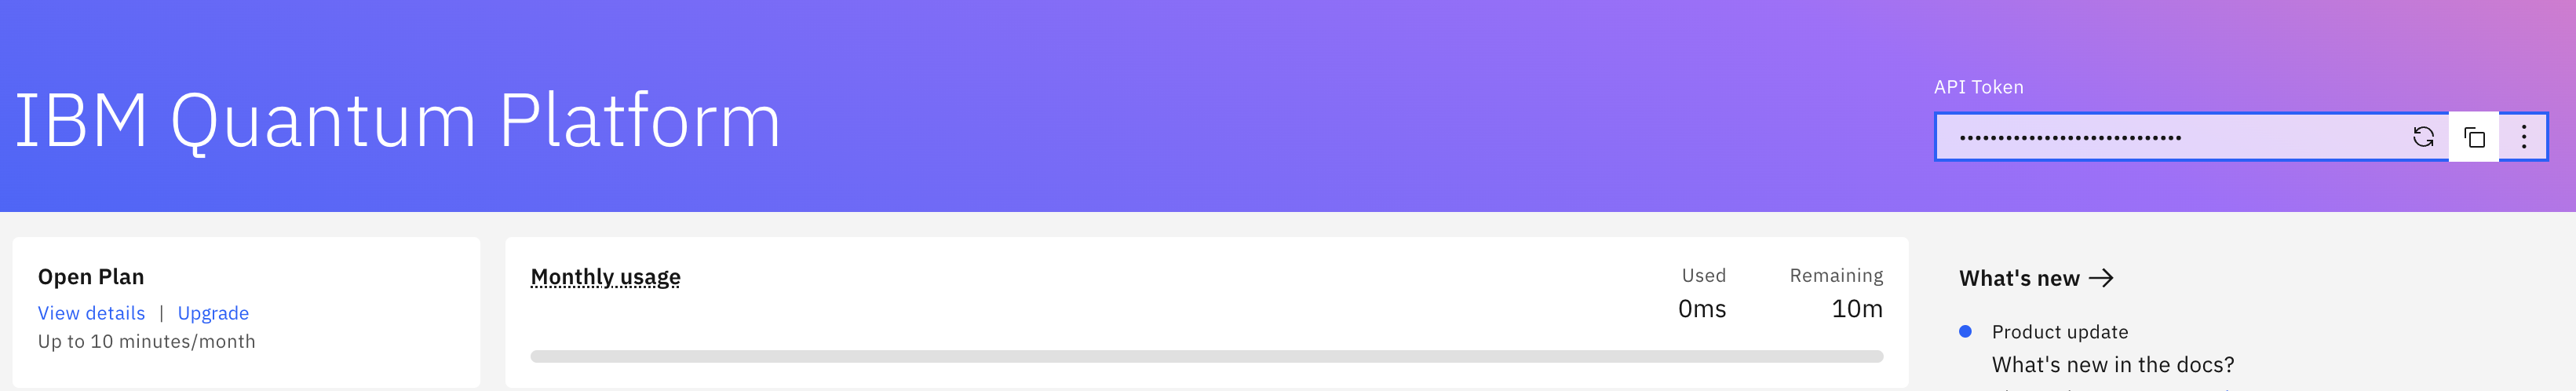

### Save your IBM Quantum account

1.   Navigate to the [IBM Quantum Platform](https://quantum.ibm.com/) and log in
2.   Look to the top right corner, click and copy your API token (pictured above)
3.   In the code cell below, replace `Your_token_here` with your token
4.   Make sure your token is inside the quotation marks!!

In [ ]:
## Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(

    channel="ibm_quantum",
    instance = 'ibm-q-ikerbasque/internal/basq-qiskit-fall'

    token="",

    set_as_default=True,

    # Use `overwrite=True` if you're updating your token.
    overwrite=True,
)

# Load saved credentials
service = QiskitRuntimeService()

### Prepare your circuit for a certain backend

The code for both of these steps is already provided below, you do not need to modify any lines.

In [ ]:
## To run on hardware, select the backend with the fewest number of jobs in the queue

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=5)
backend.name

In [ ]:
## Convert your circuit down to necessary basis gates for the backend you just selected
tr_data = [1.0, 1.0]
ts_data = [1.0, 1.0]

qc = compute_similarity(tr_data, ts_data)

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

isa_circuit = pm.run(qc)
isa_circuit.draw(output="mpl", idle_wires=False, style="iqp")

You are now ready to run your circuit on a real quantum computer!

The next code cell will send your circuit to the IBM quantum computer with the least amount of people in the queue. Depending on the device and the time of day, this can take a few minutes, or a few hours.

There are a few ways to check the status of your job while you're waiting. One is to simply go to the [IBM Quantum Platform](https://quantum.ibm.com/) and check the dashboard. We've included a picture of what that looks like after the code cell.

In [ ]:
# make a new Sampler object
sampler = Sampler(backend)

# run the experiment
job = sampler.run([isa_circuit])

# get the results
result_sampler = job.result()

# interpret the results as a "counts" dictionary
counts_sampler = result_sampler[0].data.meas.get_counts()

plot_histogram(counts_sampler)

## Congratulations!

You've made it to the end of the first notebook! Let's recap what you learned:

- **Built k-NN classifiers** using a Classical and a Quantum approach in Qiskit.
- Prepare the data **normalizing** and **encoding** a synthetic dataset, and split it into training and test sets.
- Model Design:

> Classical k-NN Classifier with Euclidean distance for **similarity**.
> 
> Quantum k-NN using **angle encoding** to map data points to quantum states and applied a **SWAP test** to measure similarity.
> 
- Use **training data** to determine neighbors of a test point for classification.
- Run a circuit on a quantum computer easily using **Qiskit Runtime**.

Now that you know a little bit about Qiskit, it is time to move onto the next Notebook and learn more. Enjoy the Qiskit Fall Fest. Good luck!